In [1]:
catalog.list()

[
    'example_iris_data',
    'parameters',
    'params:train_fraction',
    'params:random_state',
    'params:target_column'
]

In [ ]:
#init params 
isin = 'FR0000120644'
ticker = 'BN'
yahoo_ticker = 'BN.PA'

yahoo_ticker = 'OR.PA'
yahoo_ticker = 'MT'


df = yf.Ticker(yahoo_ticker)
df = yf.download(yahoo_ticker)

In [301]:
import pandas as pd 
import numpy as np
import datetime as dt 

import yfinance as yf
import pandas_datareader.data as web
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/ant/Documents/Data_science/Etam_group/Mes projets/users')
from libs import constants as c 

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows",200)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [302]:
today = dt.date.today().strftime("%Y-%m-%d")

# init constants 
c.date_start='1974-01-01'
c.date_end  =today

df_stock = yf.download('^GSPC', start=c.date_start, end=c.date_end)
df_stock = df_stock[['Close']].rename(columns={'Close':c.stock})

[*********************100%***********************]  1 of 1 completed


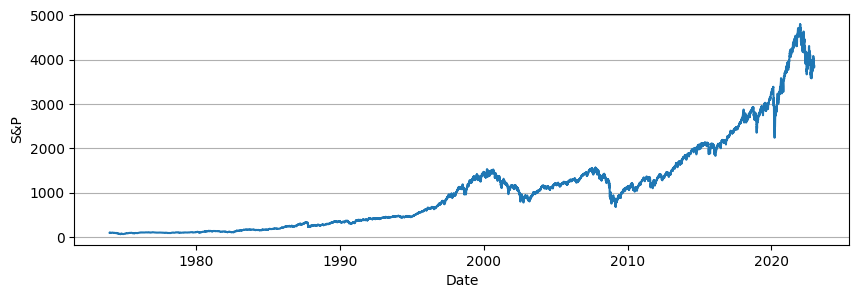

In [303]:
plt.figure(figsize=(10, 3))
plt.plot(df_stock)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("S&P")
plt.show()

In [304]:
# oil price 
wti_oil_price = web.DataReader('DCOILWTICO', 'fred', c.date_start, c.date_end)
wti_oil_price.rename(columns={'DCOILWTICO':c.oil}, inplace = True)

In [305]:
# gdp data 
gdp = web.DataReader("GDP", "fred", c.date_start, c.date_end)
gdp['shift']= gdp['GDP'].shift(1)
gdp['evol'] =(gdp['GDP']-gdp['shift'])/gdp['shift']

In [306]:
#gdp.drop(['GDP'], axis=1, inplace = True)

In [307]:
r = pd.date_range(start=c.date_start, end=c.date_end)
gdp_complete = gdp.reindex(r).fillna(method='ffill').rename_axis(c.date)

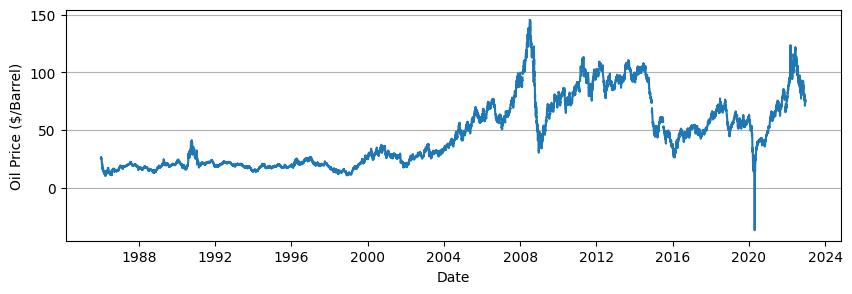

In [308]:
plt.figure(figsize=(10, 3))
plt.plot(wti_oil_price)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Oil Price ($/Barrel)")
plt.show()

In [309]:
# manage data 
wti_oil_price= wti_oil_price.reset_index()
wti_oil_price.columns = wti_oil_price.columns.str.lower()

df_stock = df_stock.reset_index()
df_stock.columns = df_stock.columns.str.lower()

gdp = gdp.reset_index()
gdp.columns = gdp.columns.str.lower()

gdp_complete = gdp_complete.reset_index()
gdp_complete.columns = gdp_complete.columns.str.lower()

In [310]:
wti_oil_price.columns

Index(['date', 'oil'], dtype='object')

In [311]:
list_features = [c.date, c.oil, c.stock]

df = pd.merge(wti_oil_price, df_stock, on ='date', how='inner').dropna()[list_features]

df[c.proxy] = df[c.stock]/df[c.oil]

In [312]:
df.shape

(9285, 4)

In [313]:
# add gdp 
df = pd.merge(df, gdp_complete, on ='date', how='inner').dropna()
df.drop(['shift'], axis=1, inplace = True)
df = df.set_index('date')

In [315]:
df.shape

(9285, 6)

In [316]:
# init 
df1, df7 = df.copy(), df.copy()

df1= df1.shift(freq = pd.DateOffset(years = 1))
# Rename columns with list
cols = [i+'_1Y' for i in df1.columns ]
df1.columns = cols 
df1 = df1.groupby(c.date).first()


df7= df7.shift(freq = pd.DateOffset(years = 7))
# Rename columns with list
cols = [i+'_7Y' for i in df7.columns ]
df7.columns = cols 
df7 = df7.groupby(c.date).first()

df = pd.merge(df, df1, left_index=True, right_index=True).drop_duplicates()
df = pd.merge(df, df7, left_index=True, right_index=True).drop_duplicates()

In [317]:
# define acceleration / deceleration of my proxy
df['evol_1Y'] = (df['proxy']- df['proxy_1Y'])/ df['proxy_1Y']
#df['evol_7Y'] = ((df['proxy']- df['proxy_7Y'])/ df['proxy_7Y'])/7
df['evol_7Y'] = (df['proxy']/df['proxy_7Y'])**(1/7)-1
# if long term trend higher than short term trend then deceleration
#df['top_acceleration'] = np.where(df['evol_1Y'] > df['evol_7Y'], 1, 0)
df['top_acceleration'] = np.where(df['evol_7Y']*0.7>df['evol_1Y'], 0, 1)

In [318]:
df.top_acceleration.value_counts()

1    2459
0    2294
Name: top_acceleration, dtype: int64

In [319]:
df.groupby(['top_acceleration'])['evol_1Y', 'evol_7Y',c.gdp].mean()

,evol_1Y,evol_7Y,gdp
top_acceleration,,,
0,-0.192690,0.033526,14591.027371
1,0.355138,0.064433,14194.967806


In [299]:
acc = df.reset_index()
acc[acc[c.date]>'2012-01-01']
#acc.describe()

,date,oil,stock,proxy,gdp,shift,evol,oil_1Y,stock_1Y,proxy_1Y,gdp_1Y,shift_1Y,evol_1Y,oil_7Y,stock_7Y,proxy_7Y,gdp_7Y,shift_7Y,evol_7Y,top_acceleration
3034,2012-01-03,102.96,1277.060059,12.403458,16068.824,15842.267,0.014301,91.59,1271.869995,13.886560,15351.444,15309.471,-0.106801,42.16,1202.079956,28.512333,12767.286,12527.214,-0.112111,0
3035,2012-01-04,103.22,1277.300049,12.374540,16068.824,15842.267,0.014301,89.39,1270.199951,14.209643,15351.444,15309.471,-0.129145,43.96,1188.050049,27.025706,12767.286,12527.214,-0.105591,0
3036,2012-01-05,101.81,1281.060059,12.582851,16068.824,15842.267,0.014301,90.30,1276.560059,14.136878,15351.444,15309.471,-0.109927,43.41,1183.739990,27.268832,12767.286,12527.214,-0.104602,0
3037,2012-01-06,101.56,1277.810059,12.581824,16068.824,15842.267,0.014301,88.37,1273.849976,14.414960,15351.444,15309.471,-0.127169,45.51,1187.890015,26.101736,12767.286,12527.214,-0.099000,0
3038,2012-01-10,102.24,1292.079956,12.637715,16068.824,15842.267,0.014301,89.24,1269.750000,14.228485,15351.444,15309.471,-0.111802,45.31,1190.250000,26.269036,12767.286,12527.214,-0.099252,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4748,2022-12-08,71.30,3963.510010,55.589201,25723.941,25248.476,0.018831,72.43,4701.209961,64.906944,24349.121,23550.420,-0.143555,37.46,2063.590088,55.087829,18332.079,18306.960,0.001295,0
4749,2022-12-09,71.05,3934.379883,55.374805,25723.941,25248.476,0.018831,70.87,4667.450195,65.859323,24349.121,23550.420,-0.159196,37.16,2047.619995,55.102799,18332.079,18306.960,0.000704,0
4750,2022-12-14,77.14,3995.320068,51.793104,25723.941,25248.476,0.018831,70.57,4634.089844,65.666570,24349.121,23550.420,-0.211271,36.31,2021.939941,55.685484,18332.079,18306.960,-0.010298,0
4751,2022-12-15,75.89,3895.750000,51.334168,25723.941,25248.476,0.018831,70.89,4709.850098,66.438850,24349.121,23550.420,-0.227347,37.32,2043.410034,54.753752,18332.079,18306.960,-0.009170,0


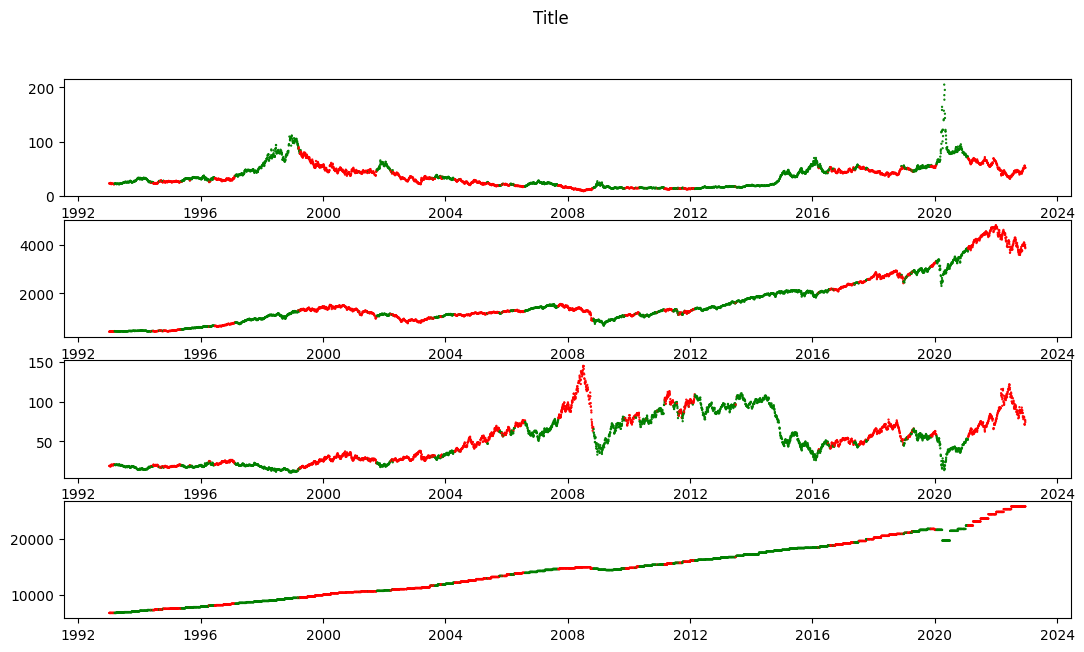

In [300]:
acc = df.reset_index()
colors = np.where(df["top_acceleration"]==1,'green','red')

fig, axs = plt.subplots(4,figsize=(13, 7))
fig.suptitle('Title')
axs[0].scatter(x=acc[c.date], y=acc[c.proxy], c=colors, s=0.4)
#axs[0].scatter(x=acc[c.date], y=acc.proxy_1Y, c=colors, s=0.1)
#axs[0].scatter(x=acc[c.date], y=acc.proxy_7Y, c=colors, s=0.1)

axs[1].scatter(x=acc[c.date], y=acc[c.stock], c=colors, s=0.4)
axs[2].scatter(x=acc[c.date], y=acc[c.oil], c=colors, s=0.4)
axs[3].scatter(x=acc[c.date], y=acc[c.gdp], c=colors, s=0.4)

plt.show()

In [343]:
list_features = [c.proxy, c.gdp, c.evol, 'top_acceleration']
acc = df.copy()
acc = acc[list_features]

r = pd.date_range(start=acc.index.min(), end=acc.index.max())
acc = acc.reindex(r).fillna(method='ffill').rename_axis(c.date)
acc = acc.reset_index()

In [344]:
acc.head(3)

,date,proxy,gdp,evol,top_acceleration
0,1993-01-06,22.833420,6729.459,0.007283,0.0
1,1993-01-07,22.765857,6729.459,0.007283,0.0
2,1993-01-08,22.701058,6729.459,0.007283,0.0


In [322]:
df.top_acceleration.value_counts()

1    2459
0    2294
Name: top_acceleration, dtype: int64

In [323]:
acc.top_acceleration.value_counts()

1.0    5645
0.0    5292
Name: top_acceleration, dtype: int64

In [324]:
df.groupby(['top_acceleration'])[c.evol].median()

top_acceleration
0    0.012299
1    0.011644
Name: evol, dtype: float64

In [325]:
acc.groupby(['top_acceleration'])[c.evol].median()

top_acceleration
0.0    0.012299
1.0    0.011644
Name: evol, dtype: float64

In [342]:
test = pd.merge(gdp, acc[[c.date, 'top_acceleration']].drop_duplicates(), on=c.date, how='left', validate='m:1')
test = test[test[c.date]>acc[c.date].min()]
test = test.reset_index(drop=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/lx/wxqypr6x7d7gj_l30f3_hd9h0000gn/T/ipykernel_9609/2463939266.py:1 in <cell line:   │
│ 1>                                                                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/lx/wxqypr6x7d7gj_l30f3_hd9h0000gn/T/ipykernel_9609/2463939266.py'                  │
│                                                                                                  │
│ /Users/ant/Documents/Data_science/Kedro_demo/py_env/lib/python3.9/site-packages/pandas/core/fram │
│ e.py:3811 in __getitem__                                                                         │
│                                                                                                  │
│    3808 │   │   else:                                                                            │
│    3809 │   │   │   if is_iterator(key):                                                         │
│    3810 │   │   │   │   key = list(key)                                                          │
│ ❱  3811 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3812 │   │                                                                                    │
│    3813 │   │   # take() does not accept boolean indexers                                        │
│    3814 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /Users/ant/Documents/Data_science/Kedro_demo/py_env/lib/python3.9/site-packages/pandas/core/inde │
│ xes/base.py:6113 in _get_indexer_strict                                                          │
│                                                                                                  │
│   6110 │   │   else:                                                                             │
│   6111 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   6112 │   │                                                                                     │
│ ❱ 6113 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   6114 │   │                                                                                     │
│   6115 │   │   keyarr = self.take(indexer)                                                       │
│   6116 │   │   if isinstance(key, Index):                                                        │
│                                                                                                  │
│ /Users/ant/Documents/Data_science/Kedro_demo/py_env/lib/python3.9/site-packages/pandas/core/inde │
│ xes/base.py:6176 in _raise_if_missing                                                            │
│                                                                                                  │
│   6173 │   │   │   │   raise KeyError(f"None of [{key}] are in the [{axis_name}]")               │
│   6174 │   │   │                                                                                 │
│   6175 │   │   │   not_found = list(ensure_index(key)[missing_mask.nonzero()[0]].unique())       │
│ ❱ 6176 │   │   │   raise KeyError(f"{not_found} not in index")                                   │
│   6177 │                                                                                         │
│   6178 │   @overload                                                                             │
│   6179 │   def _get_indexer_non_comparable(                                                      │
╰────────────────────────────────────────────────────────────

In [ ]:
test

In [327]:
list_date= []
list_gdp = []

for i in range(len(test)) :
    # init 
    row = test.loc[i]
    
    if i == 0 :
        last_gdp = row[c.gdp]
        last_date= row[c.date]
        
        list_gdp.append(last_gdp)
        list_date.append(last_date)

    else : 
        if row['top_acceleration'] == 1 :
            gdp_value = last_gdp*(1+row[c.evol])
            date_value= row[c.date]
            # update
            last_gdp = gdp_value 
            last_date = row[c.date]
        else :
            gdp_value = last_gdp
            date_value= row[c.date]
            last_date = row[c.date]

        list_gdp.append(last_gdp)
        list_date.append(last_date)        
        

In [328]:
acc = pd.DataFrame({c.date:list_date, c.gdp:list_gdp})

In [329]:
list_features = [c.proxy, c.gdp, c.evol, 'top_acceleration']
dec = df.copy()
dec = dec[list_features]

r = pd.date_range(start=dec.index.min(), end=dec.index.max())
dec = dec.reindex(r).fillna(method='ffill').rename_axis(c.date)
dec = dec.reset_index()

test = pd.merge(gdp, dec[[c.date, 'top_acceleration']].drop_duplicates(), on=c.date, how='left', validate='m:1')
test = test[test[c.date]>dec[c.date].min()]
test = test.reset_index(drop=True)

In [339]:
list_date= []
list_gdp = []
list_evol = []
for i in range(len(test)) :
    # init 
    row = test.loc[i]
    
    if i == 0 :
        last_gdp = row[c.gdp]
        last_date= row[c.date]
        last_evol= row[c.evol]
        
        list_gdp.append(last_gdp)
        list_date.append(last_date)
        list_evol.append(last_evol)

    else : 
        if row['top_acceleration'] == 0 :
            gdp_value = last_gdp*(1+row[c.evol])
            date_value= row[c.date]
            evol_value= row[c.evol]
            # update
            last_gdp  = gdp_value 
            last_date = row[c.date]
            last_evol = row[c.evol]
            
        else :
            gdp_value = last_gdp
            date_value= row[c.date]
            
            last_date = row[c.date]
            last_evol = 0

        list_gdp.append (last_gdp)
        list_date.append(last_date)
        list_evol.append(last_evol)        
        
        

In [340]:
dec = pd.DataFrame({c.date:list_date, c.gdp:list_gdp, c.evol:list_evol})

In [341]:
dec

,date,gdp,evol
0,1993-04-01,6808.939000,0.011811
1,1993-07-01,6808.939000,0.000000
2,1993-10-01,6808.939000,0.000000
3,1994-01-01,6808.939000,0.000000
4,1994-04-01,6808.939000,0.000000
5,1994-07-01,6887.997482,0.011611
6,1994-10-01,7004.703263,0.016943
7,1995-01-01,7067.654838,0.008987
8,1995-04-01,7122.814628,0.007805
9,1995-07-01,7122.814628,0.000000


In [333]:
acc

,date,gdp
0,1993-04-01,6808.939000
1,1993-07-01,6882.098000
2,1993-10-01,7013.738000
3,1994-01-01,7115.652000
4,1994-04-01,7246.931000
5,1994-07-01,7246.931000
6,1994-10-01,7246.931000
7,1995-01-01,7246.931000
8,1995-04-01,7246.931000
9,1995-07-01,7344.558603


In [334]:
res = pd.merge(acc.rename(columns={c.gdp:'gdp_boom'}), dec.rename(columns={c.gdp:'gdp_bust'}), on=c.date, how='outer')
res.shape[0]==acc.shape[0]

True

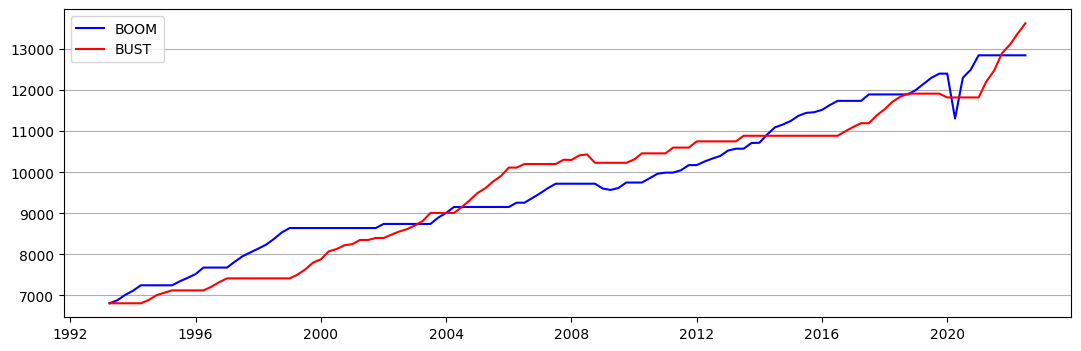

In [335]:
plt.figure(figsize=(13,4))
plt.plot(res.date, res.gdp_boom,color="blue", label="BOOM")
plt.plot(res.date, res.gdp_bust,color="red", label="BUST" )
plt.grid(axis="y")
plt.legend()
plt.show()

In [194]:
res

,date,gdp_boom,gdp_bust
0,1993-04-01,6808.939000,6808.939000
1,1993-07-01,6882.098000,6808.939000
2,1993-10-01,7013.738000,6808.939000
3,1994-01-01,7115.652000,6808.939000
4,1994-04-01,7246.931000,6808.939000
5,1994-07-01,7246.931000,6887.997482
6,1994-10-01,7246.931000,7004.703263
7,1995-01-01,7246.931000,7067.654838
8,1995-04-01,7246.931000,7122.814628
9,1995-07-01,7344.558603,7122.814628


In [164]:
test['gdp'] = np.where(test['top_acceleration']==0,np.NaN, test['gdp']) 

In [ ]:
for i in 

In [166]:
test['gdp'].fillna(method='ffill', inplace = True)
test

,date,gdp,shift,evol,top_acceleration
77,1993-04-01,6808.939,6729.459,0.011811,1.0
78,1993-07-01,6882.098,6808.939,0.010745,1.0
79,1993-10-01,7013.738,6882.098,0.019128,1.0
80,1994-01-01,7115.652,7013.738,0.014531,1.0
81,1994-04-01,7246.931,7115.652,0.018449,1.0
82,1994-07-01,7246.931,7246.931,0.011611,0.0
83,1994-10-01,7246.931,7331.075,0.016943,0.0
84,1995-01-01,7246.931,7455.288,0.008987,0.0
85,1995-04-01,7246.931,7522.289,0.007805,0.0
86,1995-07-01,7683.125,7580.997,0.013472,1.0


In [ ]:
test['gdp'].fillna(method='ffill', inplace = True)
acc = acc.set_index(c.date)

In [ ]:
acc['gdp'] = np.where(acc['top_acceleration']==1,np.NaN, acc['gdp']) 
acc['gdp'].fillna(method='ffill', inplace = True)
acc = acc.set_index(c.date)

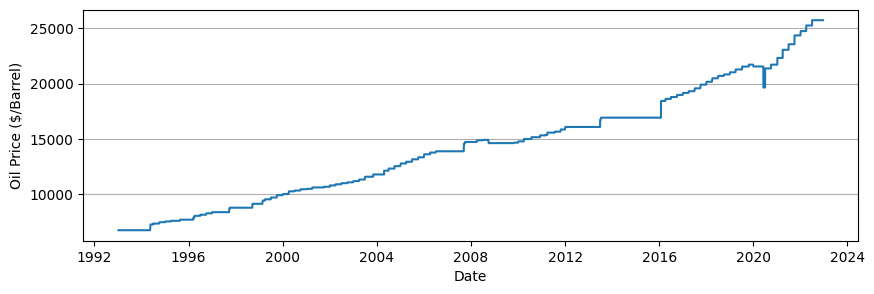

In [169]:
plt.figure(figsize=(10, 3))
plt.plot(acc[['gdp']])
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Oil Price ($/Barrel)")
plt.show()

In [145]:
acc = df[df['top_acceleration']==1]
dec = df[df['top_acceleration']==1]

In [148]:
acc

,oil,stock,proxy,gdp,oil_1Y,stock_1Y,proxy_1Y,gdp_1Y,oil_7Y,stock_7Y,proxy_7Y,gdp_7Y,evol_1Y,evol_7Y,top_acceleration
date,,,,,,,,,,,,,,,
1993-03-17,20.14,448.309998,22.259682,6729.459,19.27,409.579987,21.254800,6363.102,13.28,234.669998,17.670934,4507.894,0.047278,0.037097,1
1993-03-19,20.05,450.179993,22.452867,6729.459,19.27,409.799988,21.266216,6363.102,13.25,235.600006,17.781133,4507.894,0.055800,0.037534,1
1993-03-24,19.97,448.070007,22.437156,6729.459,19.06,408.880005,21.452256,6363.102,12.20,235.330002,19.289344,4507.894,0.045911,0.023313,1
1993-03-25,20.12,450.880005,22.409543,6729.459,19.00,407.519989,21.448420,6363.102,12.43,234.720001,18.883347,4507.894,0.044811,0.026677,1
1993-03-26,20.42,447.779999,21.928501,6729.459,19.31,407.859985,21.121698,6363.102,12.03,237.300003,19.725686,4507.894,0.038198,0.015953,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,48.18,3703.060059,76.858864,21704.706,61.17,3223.379883,52.695437,21706.532,98.87,1833.319946,18.542732,17133.114,0.458549,0.449280,1
2020-12-30,48.24,3732.040039,77.364014,21704.706,61.66,3221.290039,52.242784,21706.532,98.90,1841.069946,18.615470,17133.114,0.480856,0.450843,1
2020-12-31,48.35,3756.070068,77.685007,21704.706,61.14,3230.780029,52.842330,21706.532,98.17,1848.359985,18.828155,17133.114,0.470128,0.446572,1


In [147]:
df[['top_acceleration']]

,oil,stock,proxy,gdp,oil_1Y,stock_1Y,proxy_1Y,gdp_1Y,oil_7Y,stock_7Y,proxy_7Y,gdp_7Y,evol_1Y,evol_7Y,top_acceleration
date,,,,,,,,,,,,,,,
1993-01-06,19.03,434.519989,22.833420,6729.459,19.24,417.959991,21.723492,6363.102,26.53,210.649994,7.940068,4507.894,0.051093,0.267960,0
1993-01-07,18.92,430.730011,22.765857,6729.459,18.72,417.399994,22.297008,6363.102,25.85,213.800003,8.270793,4507.894,0.021027,0.250366,0
1993-01-08,18.90,429.049988,22.701058,6729.459,17.95,418.100006,23.292479,6363.102,25.87,207.970001,8.039041,4507.894,-0.025391,0.260550,0
1993-01-13,18.51,433.029999,23.394381,6729.459,18.77,414.339996,22.074587,6363.102,25.08,206.720001,8.242424,4507.894,0.059788,0.262613,0
1993-01-14,18.71,435.940002,23.299840,6729.459,18.40,420.440002,22.850000,6363.102,24.97,206.639999,8.275531,4507.894,0.019687,0.259359,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08,71.30,3963.510010,55.589201,25723.941,72.43,4701.209961,64.906944,24349.121,37.46,2063.590088,55.087829,18332.079,-0.143555,0.001300,0
2022-12-09,71.05,3934.379883,55.374805,25723.941,70.87,4667.450195,65.859323,24349.121,37.16,2047.619995,55.102799,18332.079,-0.159196,0.000705,0
2022-12-14,77.14,3995.320068,51.793104,25723.941,70.57,4634.089844,65.666570,24349.121,36.31,2021.939941,55.685484,18332.079,-0.211271,-0.009986,0


In [146]:
acc

,oil,stock,proxy,gdp,oil_1Y,stock_1Y,proxy_1Y,gdp_1Y,oil_7Y,stock_7Y,proxy_7Y,gdp_7Y,evol_1Y,evol_7Y,top_acceleration
date,,,,,,,,,,,,,,,
1993-03-17,20.14,448.309998,22.259682,6729.459,19.27,409.579987,21.254800,6363.102,13.28,234.669998,17.670934,4507.894,0.047278,0.037097,1
1993-03-19,20.05,450.179993,22.452867,6729.459,19.27,409.799988,21.266216,6363.102,13.25,235.600006,17.781133,4507.894,0.055800,0.037534,1
1993-03-24,19.97,448.070007,22.437156,6729.459,19.06,408.880005,21.452256,6363.102,12.20,235.330002,19.289344,4507.894,0.045911,0.023313,1
1993-03-25,20.12,450.880005,22.409543,6729.459,19.00,407.519989,21.448420,6363.102,12.43,234.720001,18.883347,4507.894,0.044811,0.026677,1
1993-03-26,20.42,447.779999,21.928501,6729.459,19.31,407.859985,21.121698,6363.102,12.03,237.300003,19.725686,4507.894,0.038198,0.015953,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,48.18,3703.060059,76.858864,21704.706,61.17,3223.379883,52.695437,21706.532,98.87,1833.319946,18.542732,17133.114,0.458549,0.449280,1
2020-12-30,48.24,3732.040039,77.364014,21704.706,61.66,3221.290039,52.242784,21706.532,98.90,1841.069946,18.615470,17133.114,0.480856,0.450843,1
2020-12-31,48.35,3756.070068,77.685007,21704.706,61.14,3230.780029,52.842330,21706.532,98.17,1848.359985,18.828155,17133.114,0.470128,0.446572,1


In [47]:
df.head(10)

,oil,stock,proxy,oil_1Y,stock_1Y,proxy_1Y,oil_7Y,stock_7Y,proxy_7Y,evol_1Y,evol_7Y,top_acceleration
date,,,,,,,,,,,,
1993-01-06,19.03,434.519989,22.833420,19.24,417.959991,21.723492,26.53,210.649994,7.940068,0.051093,1.875721,0
1993-01-07,18.92,430.730011,22.765857,18.72,417.399994,22.297008,25.85,213.800003,8.270793,0.021027,1.752560,0
1993-01-08,18.90,429.049988,22.701058,17.95,418.100006,23.292479,25.87,207.970001,8.039041,-0.025391,1.823851,0
1993-01-13,18.51,433.029999,23.394381,18.77,414.339996,22.074587,25.08,206.720001,8.242424,0.059788,1.838289,0
1993-01-14,18.71,435.940002,23.299840,18.40,420.440002,22.850000,24.97,206.639999,8.275531,0.019687,1.815510,0
1993-01-15,18.89,437.149994,23.141874,18.83,420.769989,22.345724,25.18,208.259995,8.270850,0.035629,1.798004,0
1993-01-20,18.35,433.369995,23.616893,18.92,416.359985,22.006342,21.33,207.529999,9.729489,0.073186,1.427352,0
1993-01-21,18.71,435.489990,23.275788,18.50,412.640015,22.304866,20.61,205.789993,9.984958,0.043530,1.331085,0
1993-01-22,18.64,436.109985,23.396458,18.73,418.130005,22.324079,20.25,203.490005,10.048889,0.048037,1.328263,0


In [44]:
df.tail(10)

,oil,stock,proxy,oil_1Y,stock_1Y,proxy_1Y,oil_7Y,stock_7Y,proxy_7Y
date,,,,,,,,,
2022-11-23,77.93,4027.260010,51.677916,78.32,4690.700195,59.891473,39.27,2086.590088,53.134456
2022-11-30,80.48,4080.110107,50.697193,66.14,4567.000000,69.050499,40.43,2080.409912,51.457084
2022-12-01,81.06,4076.570068,50.290773,65.44,4513.040039,68.964548,40.58,2102.629883,51.814438
2022-12-02,79.86,4071.699951,50.985474,66.60,4577.100098,68.725227,39.93,2079.510010,52.078888
2022-12-07,71.93,3933.919922,54.690948,71.94,4686.750000,65.148040,37.64,2077.070068,55.182520
2022-12-08,71.30,3963.510010,55.589201,72.43,4701.209961,64.906944,37.46,2063.590088,55.087829
2022-12-09,71.05,3934.379883,55.374805,70.87,4667.450195,65.859323,37.16,2047.619995,55.102799
2022-12-14,77.14,3995.320068,51.793104,70.57,4634.089844,65.666570,36.31,2021.939941,55.685484
2022-12-15,75.89,3895.750000,51.334168,70.89,4709.850098,66.438850,37.32,2043.410034,54.753752


In [40]:
df1.tail(10)

,oil_1Y,stock_1Y,proxy_1Y
date,,,
2023-12-06,74.21,3941.260010,53.109554
2023-12-07,71.93,3933.919922,54.690948
2023-12-08,71.30,3963.510010,55.589201
2023-12-09,71.05,3934.379883,55.374805
2023-12-12,72.96,3990.560059,54.695176
2023-12-13,75.44,4019.649902,53.282740
2023-12-14,77.14,3995.320068,51.793104
2023-12-15,75.89,3895.750000,51.334168
2023-12-16,74.19,3852.360107,51.925598


In [ ]:
df['SMA1Y'] = df['proxy'].rolling(365).mean()
df['SMA7Y'] = df['proxy'].rolling(365*7).mean()
df['SMA30D']= df['proxy'].rolling(30).mean()

In [106]:
df.head(20)

,date,dcoilwtico,close,proxy,SMA1Y,SMA7Y,SMA30D
5130,2013-06-13,96.66,164.210007,1.698841,NaN,NaN,NaN
5131,2013-06-14,97.83,163.179993,1.667995,NaN,NaN,NaN
5132,2013-06-17,97.86,164.440002,1.680360,NaN,NaN,NaN
5133,2013-06-18,98.46,165.740005,1.683323,NaN,NaN,NaN
5134,2013-06-19,98.24,163.449997,1.663783,NaN,NaN,NaN
5135,2013-06-20,94.89,159.399994,1.679840,NaN,NaN,NaN
5136,2013-06-21,93.81,159.070007,1.695662,NaN,NaN,NaN
5137,2013-06-24,95.07,157.059998,1.652046,NaN,NaN,NaN
5138,2013-06-25,95.25,158.570007,1.664777,NaN,NaN,NaN
5139,2013-06-26,95.47,160.139999,1.677386,NaN,NaN,NaN


In [104]:
df = df.set_index('date')
df1= df.shift(freq = pd.DateOffset(years = 1))


In [107]:
test.head(20)

,dcoilwtico,close,proxy,SMA1Y,SMA7Y,SMA30D
date,,,,,,
2013-06-13,96.66,164.210007,1.698841,NaN,NaN,NaN
2013-06-14,97.83,163.179993,1.667995,NaN,NaN,NaN
2013-06-17,97.86,164.440002,1.680360,NaN,NaN,NaN
2013-06-18,98.46,165.740005,1.683323,NaN,NaN,NaN
2013-06-19,98.24,163.449997,1.663783,NaN,NaN,NaN
2013-06-20,94.89,159.399994,1.679840,NaN,NaN,NaN
2013-06-21,93.81,159.070007,1.695662,NaN,NaN,NaN
2013-06-24,95.07,157.059998,1.652046,NaN,NaN,NaN
2013-06-25,95.25,158.570007,1.664777,NaN,NaN,NaN


In [110]:
test.shift(freq = pd.DateOffset(years = 1)).head(20)

,dcoilwtico,close,proxy,SMA1Y,SMA7Y,SMA30D
date,,,,,,
2014-06-13,96.66,164.210007,1.698841,NaN,NaN,NaN
2014-06-14,97.83,163.179993,1.667995,NaN,NaN,NaN
2014-06-17,97.86,164.440002,1.680360,NaN,NaN,NaN
2014-06-18,98.46,165.740005,1.683323,NaN,NaN,NaN
2014-06-19,98.24,163.449997,1.663783,NaN,NaN,NaN
2014-06-20,94.89,159.399994,1.679840,NaN,NaN,NaN
2014-06-21,93.81,159.070007,1.695662,NaN,NaN,NaN
2014-06-24,95.07,157.059998,1.652046,NaN,NaN,NaN
2014-06-25,95.25,158.570007,1.664777,NaN,NaN,NaN


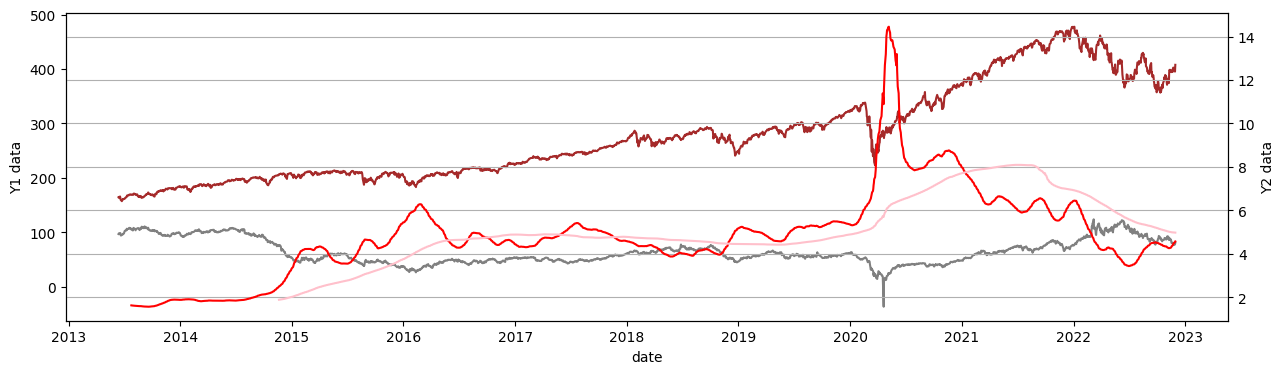

In [100]:
fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

ax1.plot(df.date, df.dcoilwtico, color="grey", label="oil")
ax1.plot(df.date, df.close, color="brown", label="S&P")
#ax2.plot(df.date, df.proxy, color="green", label="ratio")
ax2.plot(df.date, df.SMA30D, color="red", label="ratio")
ax2.plot(df.date, df.SMA1Y, color="pink", label="ratio")
ax2.plot(df.date, df.SMA7Y, color="orange", label="ratio")
ax2.grid(axis="y")
ax1.set_xlabel('date')
ax1.set_ylabel('Y1 data', color='black')
ax2.set_ylabel('Y2 data', color='black')

plt.show()


plt.figure(figsize=(13,4))
plt.grid(axis="y")
plt.plot(df.date, df.dcoilwtico,color="grey", label="oil" )
plt.plot(df.date, df.close,color="red", label="S&P" )
plt.legend()
plt.show()

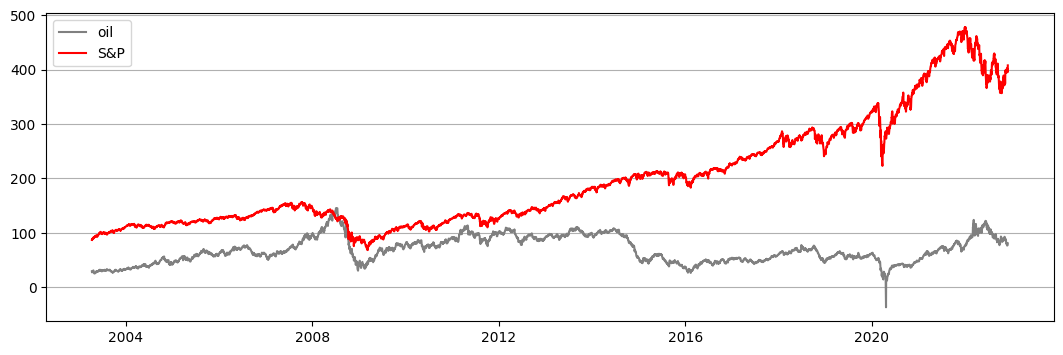

In [86]:
plt.figure(figsize=(13,4))
plt.grid(axis="y")
plt.plot(df.date, df.dcoilwtico,color="grey", label="oil" )
plt.plot(df.date, df.close,color="red", label="S&P" )
plt.legend()
plt.show()

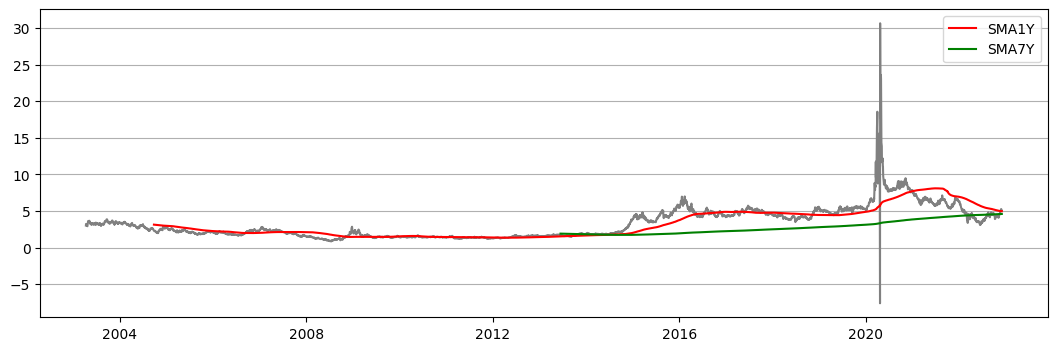

In [83]:
plt.figure(figsize=(13,4))
plt.grid(axis="y")
plt.plot(df.date, df.proxy,color="grey", label="" )
plt.plot(df.date, df.SMA1Y,color="red", label="SMA1Y" )
plt.plot(df.date, df.SMA7Y,color="green", label="SMA7Y" )
plt.legend()
plt.show()

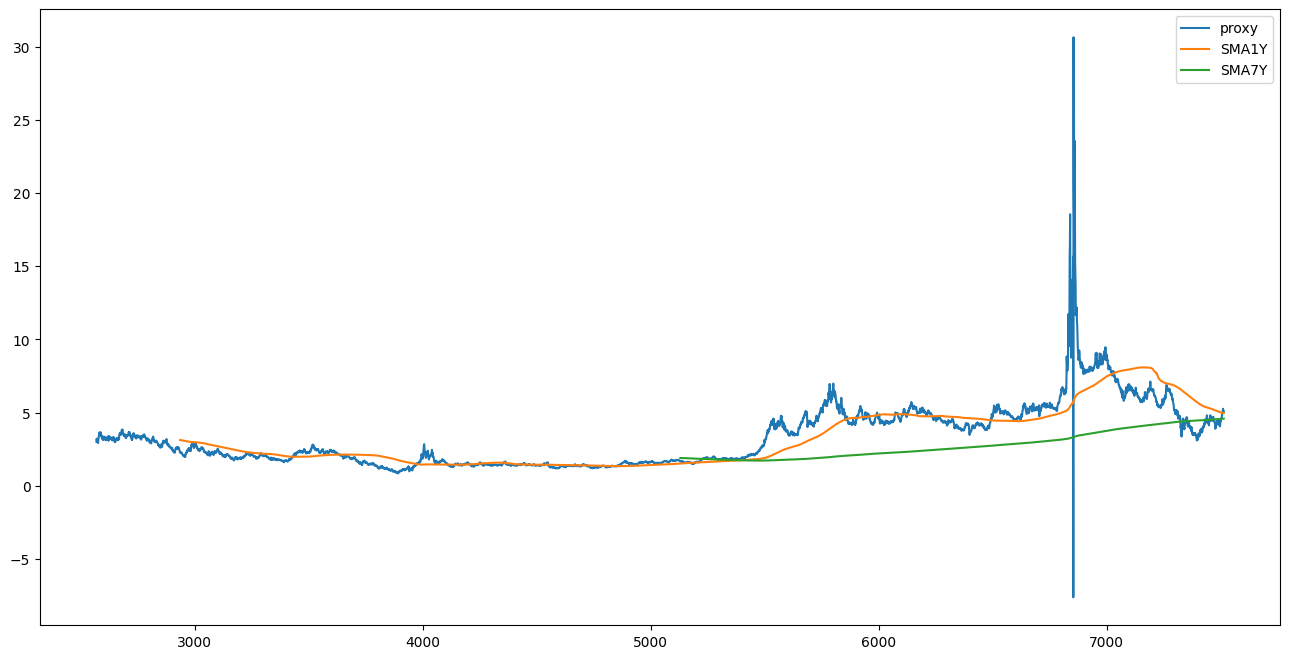

In [77]:
# plotting Close price and simple
# moving average of 30 days using .plot() method
df[['proxy', 'SMA1Y', 'SMA7Y']].plot(label='RELIANCE',figsize=(16, 8))

In [70]:
df.isnull().sum()

date          0
dcoilwtico    0
close         0
dtype: int64

In [ ]:
How is this ratio indicative of an economic boom or bust? 
Like inflation, stock prices are very sensitive to growth accelerations and decelerations: the positive or negative disparity between the sxhort-term trend (1 year), and the long-term trend (7 years).
Let us examine the USA over the past 50 years: When the S&P/Oil ratio is accelerating, real GDP grows by 3% per annum; when it is decelerating, real growth falls to 0.9%. This ratio is providing prescient information that will remain unknown to economists for months at a time.


In [39]:
df.dropna(subset=['dcoilwtico'],axis=0, inplace = True)

[12/22/22 17:49:45] WARNING  /var/folders/lx/wxqypr6x7d7gj_l30f3_hd9h0000gn/T/ipykernel_2414/205789 ]8;id=48210;file:///Users/ant/opt/anaconda3/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=79412;file:///Users/ant/opt/anaconda3/lib/python3.9/warnings.py#109\109]8;;\
                             4785.py:1: SettingWithCopyWarning:                                                    
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df.dropna(subset=['dcoilwtico'],axis=0, inplace = True)                             
                                                                                                                   

In [16]:
wti_oil_price

,date,dcoilwtico
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
...,...,...
9626,2022-11-25,76.45
9627,2022-11-28,77.10
9628,2022-11-29,77.96
9629,2022-11-30,80.48


In [ ]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2022, 5, 21)



In [ ]:

# save the data
file_path = f"{data_dir}/DCOILWTICO.csv"
wti_oil_price.to_csv(file_path)
wti_oil_price

In [2]:
pwd

'/Users/ant/Documents/Data_science/Kedro_demo/bourse/notebooks'

In [3]:
PATH_TO_PROJECT_ROOT = '/Users/ant/Documents/Data_science/Kedro_demo/bourse'

In [5]:
from kedro.framework.context import load_context

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/lx/wxqypr6x7d7gj_l30f3_hd9h0000gn/T/ipykernel_1602/1407969037.py:1 in <cell line:   │
│ 1>                                                                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/lx/wxqypr6x7d7gj_l30f3_hd9h0000gn/T/ipykernel_1602/1407969037.py'                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: cannot import name 'load_context' from 'kedro.framework.context' 
(/Users/ant/Documents/Data_science/Kedro_demo/py_env/lib/python3.9/site-packages/kedro/framework/context/__init__.p
y)

In [6]:
import 

In [7]:
from kedro.framework.context import context

In [10]:
context

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/lx/wxqypr6x7d7gj_l30f3_hd9h0000gn/T/ipykernel_1602/2606503456.py:1 in <cell line:   │
│ 1>                                                                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/lx/wxqypr6x7d7gj_l30f3_hd9h0000gn/T/ipykernel_1602/2606503456.py'                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: module 'kedro.framework.context.context' has no attribute 'context'

In [ ]:
context = load_context(PATH_TO_PROJECT_ROOT)
catalog = context.catalog

In [ ]:

output_notebook() 

def fadd_regression (data) : 
    df = data.copy()
    # add droite de regression
    m, b = np.polyfit(df['index'], df['Close'], 1)
    df['m'] = m
    df['b'] = b
    df['reg'] =  df['m']*df['index'] + df['b']
    df['stddev+']  = df['reg']+ np.std(df['reg'])
    df['2stddev+'] = df['reg']+ (2*np.std(df['reg']))
    df['stddev-']  = df['reg']- np.std(df['reg'])
    df['2stddev-'] = df['reg']- (2*np.std(df['reg']))
    return df

def fadd_MM (data) :
    df = data.copy()    
    # add MM
    df["MM20"] = df['Close'].rolling(20).mean()
    df["MM50"] = df['Close'].rolling(50).mean()
    df["MM100"] = df['Close'].rolling(100).mean()
    return df 

def fmanageDataYahoo (data, datemin, datemax =dt.date.today().strftime('%Y-%m-%d')) : 
    df = data.reset_index().copy()
    # Converting date to pandas datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    # Getting week number
    df['Week_Number'] = df['Date'].dt.week
    # Getting year. Weeknum is common across years to we need to create unique index by using year and weeknum
    df['Year'] = df['Date'].dt.year
    df['Open J+1'] = df['Open'].shift(-1)
    df['Open J+1'].fillna(df['Close'], inplace = True)
    # filter 
    df = df[(df['Date']>=datemin)&(df['Date']<=datemax)]

    return df 

def fmakeDailyBasis (data) : 
    df = data.copy()
    df = df.reset_index(drop = True).reset_index()
    # add information
    df = fadd_regression (df)
    df = fadd_MM (df)

    return df 

def fmakeWeeklyBasis (data) : 
    df = data.copy()
    # Grouping based on Weekly values
    df = df.groupby([#'ticker', 
                     'Year',
                     'Week_Number']).agg({'Date':'min', 
                                                'Open':'first',
                                                'Open J+1':'last',
                                                'High':'max', 
                                                'Low':'min', 
                                                'Close':'last',
                                                'Volume':'sum',
                                                #'Dividends':'sum',
                                                #'Stock Splits':'sum',
                                                })
    df.reset_index(inplace = True)
    df = df.reset_index(drop = True).reset_index()
    df = fadd_regression (df)
    df = fadd_MM (df)
    df.set_index('Date', inplace = True)
    return df

def fvisubokeh (data) :
    df = data.copy()
    df['DateBokeh'] = df['Date'].dt.strftime('%Y-%m-%d')
    source = ColumnDataSource(data=df)
    TOOLS = ["zoom_in,zoom_out,pan,box_select,reset"]#"hover","crosshair,,wheel_zoom,box_zoom,reset,,lasso_select","box_select","reset",

    TOOLTIPS = [#('nom', "@ticker"),
                ('close', "@Close"),
                ('date', "@DateBokeh"),
                ]

    p = figure(plot_width=1000, 
               plot_height=500,
               #title = 'Stock evolution of "ticker" : ' + ticker,
               x_axis_type="datetime",
               tooltips=TOOLTIPS,
               tools =TOOLS,
               #y_range=(mindata, maxdata),
               y_axis_label='Stock Price',
           )
    # add a line 
    p.line('Date', 'Close'  , line_width=1  , color="blue"   , source=source)
    p.line('Date', 'reg'    , line_width=2  , color="orange"    , source=source)
    p.line('Date', 'stddev+', line_width=1  , color="grey"    , source=source)
    p.line('Date', 'stddev-', line_width=1  , color="grey"    , source=source) #hover_color="orange",
    p.line('Date', '2stddev+', line_width=1  , color="grey"    , source=source)
    p.line('Date', '2stddev-', line_width=1  , color="grey"    , source=source) #hover_color="orange",
    p.line('Date', 'MM20'   , line_width=1.5  , color="red"    , source=source)
    p.line('Date', 'MM50'   , line_width=1, color="green"    , source=source)
    p.line('Date', 'MM100'  , line_width=1, color="blue"  , source=source)
    p.xaxis.axis_label = 'Date'
    tot = column(p)#,pmacd)
    # show results 
    show(tot)

def fmake_delta_date(startDate, deltaDays):
    """Generate a date at a given interval from original date."""
    return str(dt.date(int(startDate[:4]), int(startDate[5:7]), int(startDate[8:])) + timedelta(deltaDays))



def fget_days_between_two_dates (datebegin, dateend): 
    print ('inputs has to be string date with the following format : "AAAA-MM-DD" ')

    begin = dt.date(int(datebegin[:4]), int(datebegin[5:7]), int(datebegin[8:]))
    end = dt.date(int(dateend[:4]), int(dateend[5:7]), int(dateend[8:]))

    next_day = begin
    list_days = []

    while True:
        if next_day > end:
            break
        #print (next_day)
        list_days.append (next_day) # .strftime('%Y-%m-%d')
        next_day += dt.timedelta(days=1)

    return list_days


def fadd_regression_run (data) : 
    df = data.copy()
    df['reg'] =  df['m']*df['index'] + df['b']
    df['stddev+']  = df['reg']+ np.std(df['reg'])
    df['2stddevaa+'] = df['reg']+ (2*np.std(df['reg']))
    df['stddev-']  = df['reg']- np.std(df['reg'])
    df['2stddev-'] = df['reg']- (2*np.std(df['reg']))
    return df 



